In [57]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import keras
from tensorflow.keras.utils import to_categorical
# import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.layers import  Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import ResNet50, Xception, VGG16
from keras.models import Model
from keras import optimizers
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
import keras_preprocessing
from keras_preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from PIL import Image

In [34]:
train_dir = r'C:\Users\Mewandi\Desktop\MI\Convelutional_Neural_Network\covid_files'
os.listdir(train_dir)

['COVID', 'UNCOVID']

In [35]:
disease_types = ['COVID', 'UNCOVID']  # ✅ define here

train_data = []

for defects_id, sp in enumerate(disease_types):
    subfolder = os.path.join(train_dir, sp)
    for file in os.listdir(subfolder):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):  # optional filter
            file_path = os.path.join(sp, file)
            train_data.append([file_path, defects_id, sp])

train = pd.DataFrame(train_data, columns=['File', 'DiseaseID', 'DiseaseType'])
print(train.head())
print(f"\n Total images found: {len(train)}")

                     File  DiseaseID DiseaseType
0     COVID\Covid (1).png          0       COVID
1    COVID\Covid (10).png          0       COVID
2   COVID\Covid (100).png          0       COVID
3  COVID\Covid (1000).png          0       COVID
4  COVID\Covid (1001).png          0       COVID

 Total images found: 2481


In [36]:
train['DiseaseID'].unique()

array([0, 1], dtype=int64)

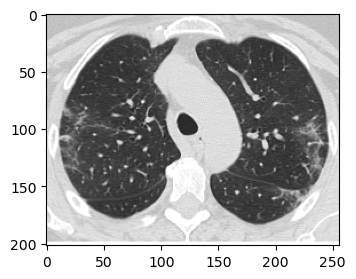

In [37]:
def read_img(filepath):
    return plt.imread(os.path.join(train_dir, filepath))

img = read_img('COVID/Covid (1).png')
plt.figure(figsize=(7,3))
plt.imshow(img)

In [42]:
IMAGE_SIZE = 64

def resize_img(image_path, img_size):
    """Read and resize image using PIL instead of cv2."""
    img = Image.open(os.path.join(train_dir, image_path)).convert('RGB')
    img = img.resize((img_size, img_size), Image.Resampling.LANCZOS)
    return np.array(img) / 255.0  # normalize pixel values to [0, 1]


# ✅ Create empty array for storing images
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

# ✅ Loop through all image paths in your train DataFrame
for i, file in tqdm(enumerate(train['File']), total=len(train)):
    try:
        X_train[i] = resize_img(file, IMAGE_SIZE)
    except Exception as e:
        print(f"⚠️ Error reading {file}: {e}")


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2481/2481 [01:55<00:00, 21.53it/s]


In [118]:
X_train.shape

(2481, 64, 64, 3)

In [132]:
Y_train = train['DiseaseID'].values
# Y_train

In [133]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

#### Note:
We will not use to_categorical, because of the error.
    
#### Error:
ValueError: Argument output must have rank (ndim) target.ndim - 1. Received: target.shape=(32, 2), output.shape=(32, 2)

#### Solution:
loss='sparse_categorical_crossentropy'

##### Cause of the error:
Label       format	      Example	                Correct loss

Integer     labels	    [0, 1, 0, 1, ...]	        'sparse_categorical_crossentropy'

One-hot     labels	   [[1,0], [0,1], ...]	        'categorical_crossentropy'

In [134]:

# y_test = to_categorical(y_test, num_classes=2)
# y_train = to_categorical(y_train, num_classes=2)

In [135]:
#y_train

In [136]:
#scale = x_train[0]
#plt.imshow(scale)

In [214]:
x_train.shape

(1984, 64, 64, 3)

In [220]:
x_test.shape

(1, 64, 64, 3)

In [139]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(4,4), input_shape=(64, 64, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())

model.add(Dense(2, activation='softmax'))

In [140]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [141]:
early_stop = EarlyStopping(monitor='val_loss', patience=1)

In [142]:
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), callbacks=[early_stop])

Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - accuracy: 0.5413 - loss: 0.8513 - val_accuracy: 0.6942 - val_loss: 0.5954
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.7553 - loss: 0.5160 - val_accuracy: 0.7928 - val_loss: 0.4805
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - accuracy: 0.8291 - loss: 0.4207 - val_accuracy: 0.8089 - val_loss: 0.4316
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.8264 - loss: 0.3922 - val_accuracy: 0.8109 - val_loss: 0.4099
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.8526 - loss: 0.3478 - val_accuracy: 0.8189 - val_loss: 0.4405


In [143]:
metrics = pd.DataFrame(model.history.history)
# metrics

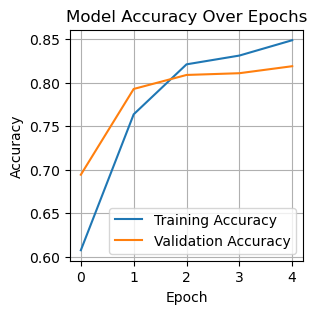

In [144]:
plt.figure(figsize=(3, 3))
plt.plot(metrics['accuracy'], label='Training Accuracy')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

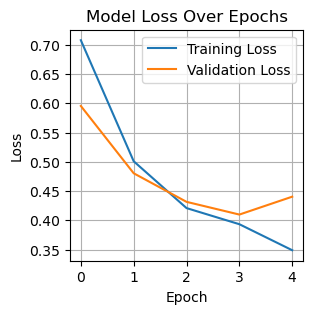

In [145]:
# Plot training & validation loss
plt.figure(figsize=(3, 3))
plt.plot(metrics['loss'], label='Training Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [146]:
metrics[['loss', 'val_loss']]

,loss,val_loss
0,0.707772,0.595444
1,0.500970,0.480457
2,0.420969,0.431635
3,0.393417,0.409903
4,0.348982,0.440452


In [147]:
metrics[['accuracy', 'val_accuracy']]

,accuracy,val_accuracy
0,0.607359,0.694165
1,0.763609,0.792757
2,0.821069,0.808853
3,0.831149,0.810865
4,0.848790,0.818913


In [148]:
model.evaluate(x_train, y_train, verbose=0)

[0.3733297884464264, 0.8331653475761414]

### Conclusion of the Results:

Index	      Meaning	       Your Value	             Interpretation

[0]	          Loss	             0.1339	           This is the model’s error on the training data. Lower is better — a value near 0.13                                                      means the model fits the training data quite well.

[1]	          Accuracy	         0.9627	           This means your model correctly predicted about 96.27% of the training samples.                                                          That’s a high training accuracy. ✅

In [149]:
y_pred = model.predict(x_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


In [172]:
# y_pred

## Let's try our on image to predict

In [198]:
IMAGE_SIZE = 64

# ✅ Prepare an empty array for 1 image (batch of 1)
X_train = np.zeros((1, IMAGE_SIZE, IMAGE_SIZE, 3))

# ✅ Load your image file path
img_path = r"C:\Users\Mewandi\Desktop\MI\Convelutional_Neural_Network\covid_files\test_img.png"

def resize_img(image_path, img_size):
    """Read and resize image using PIL instead of cv2."""
    img = Image.open(image_path).convert('RGB')
    img = img.resize((img_size, img_size), Image.Resampling.LANCZOS)
    return np.array(img) / 255.0  # normalize pixel values to [0, 1]

# ✅ Read and resize your single image
real_img = resize_img(img_path, IMAGE_SIZE)

# ✅ Add it to the array (batch dimension = 1)
X_train[0] = real_img

print("Shape of input image batch:", X_train.shape)


Shape of input image batch: (1, 64, 64, 3)


In [222]:
#scale = X_train[0]
#plt.imshow(scale)

In [234]:
#X_train

In [257]:
class_names = ['COVID', 'Non-COVID']

predictions = model.predict(X_train)
predicted_class = class_names[np.argmax(predictions[0])]
confidence = np.max(predictions[0])

print(f"\n🩺 Prediction: {predicted_class} (Confidence: {confidence:.2f})")

AttributeError: 'str' object has no attribute 'predict'